In [3]:
import numpy as np
import pandas as pd

In [4]:
import tensorflow as tf
from keras import layers
from keras import models

## Creating a model

In [5]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

In [6]:
# transform 3D vector to 1D vector
model.add(layers.Flatten())

# classification network
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

## Downloading MNIST dataset

In [7]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [8]:
(X, y), (X_test, y_test) = mnist.load_data()
type(X), X.shape

(numpy.ndarray, (60000, 28, 28))

In [9]:
X = X.reshape(X.shape[0], 28, 28, 1)
X = X / 255.

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_test = X_test / 255.

y = to_categorical(y)
y_test = to_categorical(y_test)

## Confusion Matrix

In [29]:
import io
import itertools
import sklearn.metrics

import matplotlib.pyplot as plt

In [30]:
import datetime
log_dir = 'log\\fit\\' + datetime.datetime.now().strftime("%d-%m-%Y %H-%M-%S")

In [31]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [32]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [33]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(X_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

## Fit the model

In [34]:
# split train dataset into train and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [35]:
# callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

# tensorboard callback
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = log_confusion_matrix)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [36]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 20, batch_size = 64, 
          validation_data = (X_val, y_val), 
          callbacks = [tensorboard_callback, cm_callback, early_stop_callback])

Epoch 1/20
750/750 [==============================] - 30s 39ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0541 - val_accuracy: 0.9879
Epoch 2/20
750/750 [==============================] - 33s 43ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0422 - val_accuracy: 0.9912
Epoch 3/20
750/750 [==============================] - 35s 47ms/step - loss: 0.0065 - accuracy: 0.9975 - val_loss: 0.0504 - val_accuracy: 0.9890
Epoch 4/20
750/750 [==============================] - 33s 45ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0448 - val_accuracy: 0.9902
Epoch 5/20
750/750 [==============================] - 30s 40ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0604 - val_accuracy: 0.9895


In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test)
test_loss, test_acc

313/313 [==============================] - 3s 11ms/step - loss: 0.0368 - accuracy: 0.9908


(0.036770544946193695, 0.9908000230789185)

In [38]:
y_pred = model.predict(X_test)
y_pred[0]

array([5.1781523e-13, 2.9338382e-14, 1.6386141e-11, 3.5506286e-14,
       8.8900559e-10, 8.2861130e-17, 1.7263666e-18, 1.0000000e+00,
       1.1009630e-12, 5.0272716e-12], dtype=float32)

In [39]:
y_pred = [np.argmax(i) for i in y_pred]
y_pred[0]

7

In [40]:
ind = []

for i in range(len(y_pred)):
    if np.argmax(y_test[i]) != y_pred[i]:
        ind.append(i)

Predicted:  5
Real:  3


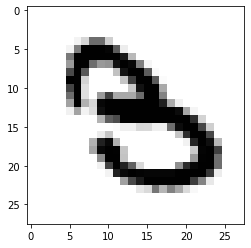

Predicted:  2
Real:  3


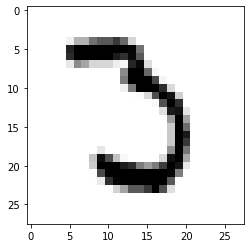

Predicted:  8
Real:  9


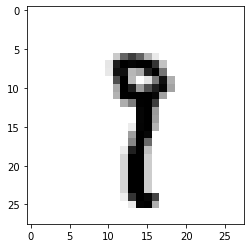

Predicted:  4
Real:  2


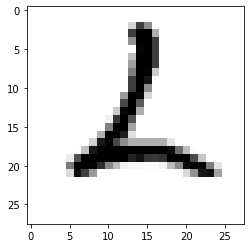

Predicted:  2
Real:  3


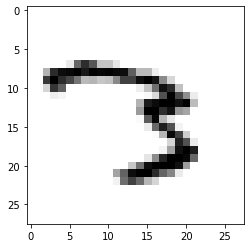

Predicted:  0
Real:  6


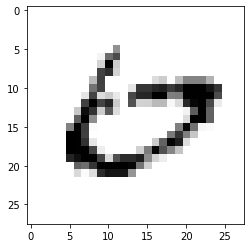

Predicted:  5
Real:  3


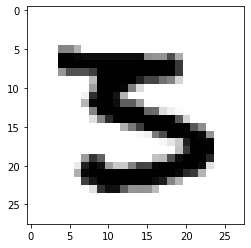

Predicted:  8
Real:  5


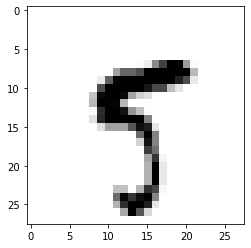

Predicted:  2
Real:  8


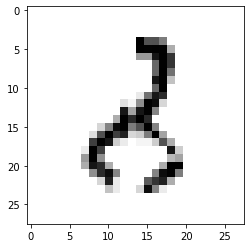

Predicted:  4
Real:  6


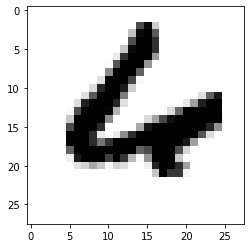

In [41]:
for i in ind[:10]:
    print('Predicted: ', y_pred[i])
    print('Real: ', np.argmax(y_test[i]))
    digit = X_test[i].reshape(28, 28)
    plt.imshow(digit, cmap=plt.cm.binary)
    plt.show()

## TensorBoard

In [ ]:
# use this lines in cmd to kill tensorboard process
# taskkill /im tensorboard.exe /f
# del /q %TMP%\.tensorboard-info\*

In [42]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "log/fit"